# Connect to drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL Chall Development/challenge_neural_network_fra

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/18AaKjaA7ofMLFgna2xwkkmzZeSbBTxeE/challenge_neural_network_fra


# Import

In [2]:
seed=42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)

import logging
import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tfk.utils.set_random_seed(42)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# Import other libraries
import pandas as pd
import matplotlib as mpl
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



# Load data

In [5]:
# load dataset
data = np.load('clean_public_data_no_duplicates.npz', allow_pickle=True)
X = data['data']
labels = data['labels']


# encode labels
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # note: 0 is [1,0]

# Split data into train_val and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.80, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, stratify=y_val_test, shuffle=True)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Print shapes of the datasets
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")





X_train shape: (970, 96, 96, 3), y_train shape: (970,)
X_val shape: (1552, 96, 96, 3), y_val shape: (1552,)
X_test shape: (2328, 96, 96, 3), y_test shape: (2328,)


In [6]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Build the ensamble models



In [7]:
##laod the models
model1 = tfk.models.load_model('augmentedDatasetConvnextLargeFT160689')
model2 = tfk.models.load_model('augmentedDatasetConvnextLargeFTMax')
model3 = tfk.models.load_model('augmentedDatasetConvnextLargeFT1413')


Model: "modellus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 convnext1 (Functional)      (None, 1)                    1966240   ['input_1[0][0]']             
                                                          65                                      
                                                                                                  
 convnext2 (Functional)      (None, 1)                    1966240   ['input_1[0][0]']             
                                                          65                                      
                                                                                           

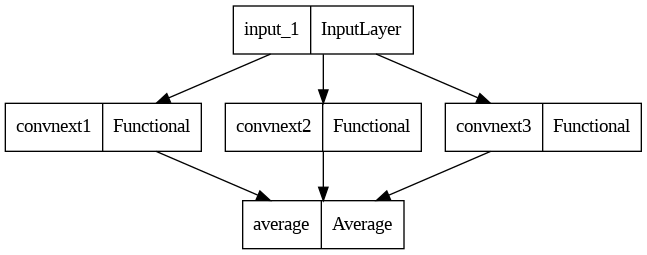

In [8]:
#freeze all the weigths
model2.trainable = False
model1.trainable = False
model3.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))


model1._name = "convnext1"
model2._name = "convnext2"
model3._name = "convnext3"

# Connect efficientnet to the input
x1m1 = model1(inputs, training=False)
x1m2 = model2(inputs, training=False)
x1m3 = model3(inputs, training=False)

output=tfkl.Average( dtype='float32')([x1m1,x1m2,x1m3])
# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=output, name='modellus')

# Display model summary
tl_model.summary()
tfk.utils.plot_model(tl_model)

In [9]:
# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()], weighted_metrics=['accuracy'])


## Evaluate the model

In [10]:
# Evaluate the model on the test set
test_accuracy = tl_model.evaluate(preprocess_input(X_test),y_test,verbose=0, return_dict=True)
print(test_accuracy)
# Evaluate the model on the test set
val_accuracy = tl_model.evaluate(preprocess_input(X_val),y_val,verbose=0, return_dict=True)
print(val_accuracy)
# Evaluate the model on the test set
train_accuracy = tl_model.evaluate(preprocess_input(X_train),y_train,verbose=0, return_dict=True)
print(train_accuracy)

{'loss': 0.09493193030357361, 'accuracy': 0.9652062058448792, 'precision': 0.9630952477455139, 'recall': 0.9417927861213684, 'weighted_accuracy': 0.9652062058448792}
{'loss': 0.10885801166296005, 'accuracy': 0.9568299055099487, 'precision': 0.9517857432365417, 'recall': 0.9301919937133789, 'weighted_accuracy': 0.9568299055099487}
{'loss': 0.09808094799518585, 'accuracy': 0.960824728012085, 'precision': 0.9624277353286743, 'recall': 0.9301676154136658, 'weighted_accuracy': 0.960824728012085}


In [11]:
y_prediction = tl_model.predict(X_test)
print(y_test.shape)
#y_prediction_bin = np.argmax (y_prediction, axis = -1)
#y_test_bin=np.argmax(y_test, axis=-1)
y_prediction_bin= ((y_prediction > 0.5)+0).ravel()
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction_bin)
print(result)

73/73 [==============================] - 54s 595ms/step
(2328,)
[[1438   31]
 [  50  809]]


In [13]:
# Save the best model
%cd /gdrive/My Drive/AN2DL Chall Development
tl_model.save('EnsembleLearningFinal')


/gdrive/My Drive/AN2DL Chall Development


In [ ]:
del tl_model